In [4]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
import scipy as sp
import math
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
from IPython.display import Markdown, display
from sklearn import metrics

%matplotlib inline

In [162]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data.index)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data.iloc[i+SEQUENCE_SIZE]
        window = [row.values for index, row in window.iterrows()]
        x.append(window)
        y.append(after_window['Close'])
        
    return np.array(x),np.array(y)

# Data Preprocessing

In [54]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')
#df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']

In [55]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [56]:
# Rearrange the columns
df = df[['Open', 'High', 'Low', 'Volume', 'Close']]
df.head()

,Open,High,Low,Volume,Close
0,3.812500,4.156250,3.812500,3675600,4.125000
1,4.125000,4.125000,4.000000,1077600,4.015625
2,4.000000,4.031250,3.953125,437200,4.000000
3,4.000000,4.000000,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,7931600,3.390625


In [57]:
df.isnull().any()

Open      False
High      False
Low       False
Volume    False
Close     False
dtype: bool

In [58]:
#df['Open'] = zscore(df['Open'])
#df['High'] = zscore(df['High'])
#df['Low'] = zscore(df['Low'])
#df['Volume'] = zscore(df['Volume'])
encode_numeric_zscore(df, 'Open')
encode_numeric_zscore(df, 'High')
encode_numeric_zscore(df, 'Low')
encode_numeric_zscore(df, 'Volume')
print(df.shape)
df.head()

(4392, 5)


,Open,High,Low,Volume,Close
0,-0.894209,-0.885022,-0.892306,1.104812,4.125000
1,-0.883762,-0.886056,-0.885975,-0.497301,4.015625
2,-0.887941,-0.889159,-0.887558,-0.892217,4.000000
3,-0.887941,-0.890194,-0.891251,-0.000263,3.843750
4,-0.896820,-0.898986,-0.906551,3.729366,3.390625


In [59]:
x, y = to_xy(df, 'Close')

In [60]:
x[0:5]

array([[-8.9420879e-01, -8.8502169e-01, -8.9230639e-01,  1.1048120e+00],
       [-8.8376242e-01, -8.8605607e-01, -8.8597530e-01, -4.9730068e-01],
       [-8.8794094e-01, -8.8915926e-01, -8.8755810e-01, -8.9221716e-01],
       [-8.8794094e-01, -8.9019364e-01, -8.9125121e-01, -2.6340524e-04],
       [-8.9682037e-01, -8.9898598e-01, -9.0655136e-01,  3.7293661e+00]],
      dtype=float32)

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

In [84]:
x_train.shape

(3074, 4)

# Fully Connected Neural Network

In [168]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Embedding
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

In [76]:
checkpointer = ModelCheckpoint(filepath="save/nn.hdf5", verbose=0, save_best_only=True) # save best model
activation_func = ['relu']
optimizer_func = ['adam']
for i in range(len(activation_func)):
    for j in range(len(optimizer_func)):
        printmd("**Activation** = {}  **Optimizer** = {} ".format(activation_func[i], optimizer_func[j]))
        model = Sequential()

        model.add(Dense(25, input_dim=x_train.shape[1], activation=activation_func[i])) # Hidden 1     #  why input_dim=x.shape[1]?  
        model.add(Dropout(0.2))
        model.add(Dense(10, activation=activation_func[i])) # Hidden 2
        model.add(Dense(1)) # Output

        model.compile(loss='mean_squared_error', optimizer=optimizer_func[j], metrics=['accuracy'])

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=500, batch_size=128, shuffle=True)

print('Training finished...Loading the best model')  
print()
model.load_weights("save/nn.hdf5") # load weights from best model    

**Activation** = relu  **Optimizer** = adam 

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 3s - loss: 1740.8611 - acc: 0.0000e+00 - val_loss: 1886.3924 - val_acc: 0.0000e+00
Epoch 2/500
 - 0s - loss: 1697.4837 - acc: 0.0000e+00 - val_loss: 1829.3406 - val_acc: 0.0000e+00
Epoch 3/500
 - 0s - loss: 1633.4513 - acc: 0.0000e+00 - val_loss: 1749.5545 - val_acc: 0.0000e+00
Epoch 4/500
 - 0s - loss: 1548.3373 - acc: 0.0000e+00 - val_loss: 1627.1984 - val_acc: 0.0000e+00
Epoch 5/500
 - 0s - loss: 1420.4473 - acc: 3.2531e-04 - val_loss: 1455.1072 - val_acc: 0.0000e+00
Epoch 6/500
 - 0s - loss: 1237.2234 - acc: 3.2531e-04 - val_loss: 1217.7634 - val_acc: 0.0000e+00
Epoch 7/500
 - 0s - loss: 1003.8087 - acc: 9.7593e-04 - val_loss: 939.7263 - val_acc: 7.5873e-04
Epoch 8/500
 - 0s - loss: 756.1648 - acc: 3.2531e-04 - val_loss: 665.0821 - val_acc: 0.0000e+00
Epoch 9/500
 - 0s - loss: 509.3234 - acc: 3.2531e-04 - val_loss: 409.0013 - val_acc: 0.0000e+00
Epoch 10/500
 - 0s - loss: 305.1235 - acc: 0.0000e+00 - val_loss: 227.7654 

In [77]:
nn_pred = model.predict(x_test)

nn_rmse = np.sqrt(metrics.mean_squared_error(nn_pred, y_test))
printmd("-----------------**Fully-Connected Neural Network Report**---------------")
print("RMSE score: {}".format(nn_rmse))

-----------------**Fully-Connected Neural Network Report**---------------

RMSE score: 0.7014450430870056


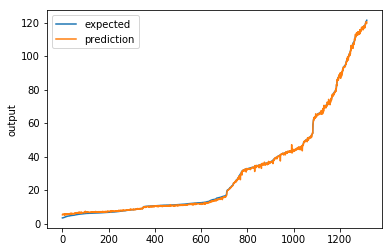

In [82]:
chart_regression(nn_pred.flatten(), y_test)

# LSTM model

In [164]:
SEQUENCE_SIZE = 7
df_train = df[0:3074]
df_test = df[3075:]

x_train,y_train = to_sequences(SEQUENCE_SIZE,df_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,df_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3066, 7, 5)
Shape of x_test: (1309, 7, 5)
Shape of y_train: (3066,)
Shape of y_test: (1309,)


In [180]:
model = Sequential()

model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(SEQUENCE_SIZE, x_train.shape[2])))
model.add(Dropout(0.25))
model.add(Dense(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2, epochs=100, batch_size=64)  

Train on 3066 samples, validate on 1309 samples
Epoch 1/100
 - 5s - loss: 99.8952 - acc: 9.7847e-04 - val_loss: 284.8958 - val_acc: 0.0000e+00
Epoch 2/100
 - 1s - loss: 45.1445 - acc: 0.0020 - val_loss: 359.8721 - val_acc: 0.0000e+00
Epoch 3/100
 - 1s - loss: 28.0681 - acc: 0.0020 - val_loss: 359.9064 - val_acc: 0.0000e+00
Epoch 4/100
 - 1s - loss: 21.6724 - acc: 0.0016 - val_loss: 159.7214 - val_acc: 0.0000e+00
Epoch 5/100
 - 1s - loss: 14.9972 - acc: 0.0020 - val_loss: 327.8095 - val_acc: 0.0000e+00
Epoch 6/100
 - 1s - loss: 13.5630 - acc: 0.0023 - val_loss: 293.4437 - val_acc: 0.0000e+00
Epoch 7/100
 - 1s - loss: 12.2747 - acc: 0.0026 - val_loss: 136.2847 - val_acc: 0.0000e+00
Epoch 8/100
 - 1s - loss: 11.1441 - acc: 0.0029 - val_loss: 164.2204 - val_acc: 0.0000e+00
Epoch 9/100
 - 1s - loss: 14.1348 - acc: 0.0033 - val_loss: 233.8517 - val_acc: 0.0000e+00
Epoch 10/100
 - 1s - loss: 9.3313 - acc: 0.0029 - val_loss: 161.5370 - val_acc: 0.0000e+00
Epoch 11/100
 - 1s - loss: 10.3835 - a

In [177]:
lstm_pred = model.predict(x_test)
lstm_rmse = np.sqrt(metrics.mean_squared_error(lstm_pred,y_test))
print("Score (RMSE): {}".format(lstm_rmse))

Score (RMSE): 16.58448006798713


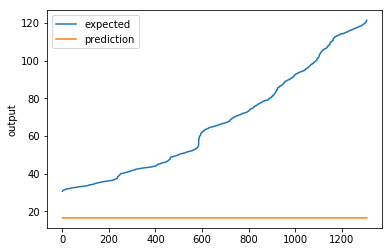

In [178]:
chart_regression(lstm_rmse, y_test)

In [151]:
temp = np.array(x)
temp

array([[[-8.83762414e-01, -8.86056090e-01, -8.85975321e-01,
         -4.97300682e-01,  4.01562500e+00],
        [-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
         -8.92217148e-01,  4.00000000e+00],
        [-8.87940954e-01, -8.90193659e-01, -8.91251228e-01,
         -2.63405247e-04,  3.84375000e+00],
        [-8.96820350e-01, -8.98985994e-01, -9.06551358e-01,
          3.72936618e+00,  3.39062500e+00],
        [-9.04655112e-01, -9.00020387e-01, -9.04968586e-01,
          5.92175691e+00,  3.43750000e+00],
        [-9.03610477e-01, -9.04157956e-01, -9.16575581e-01,
          6.93926498e+00,  3.50000000e+00],
        [-9.05699747e-01, -9.04675152e-01, -9.04440995e-01,
          2.75379178e+00,  3.48437500e+00]],

       [[-8.83762414e-01, -8.86056090e-01, -8.85975321e-01,
         -4.97300682e-01,  4.01562500e+00],
        [-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
         -8.92217148e-01,  4.00000000e+00],
        [-8.87940954e-01, -8.90193659e-01, -8.91251228e-01,
  

In [121]:
temp

array([[[-8.83762414e-01, -8.86056090e-01, -8.85975321e-01,
         -4.97300682e-01,  4.01562500e+00],
        [-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
         -8.92217148e-01,  4.00000000e+00],
        [-8.87940954e-01, -8.90193659e-01, -8.91251228e-01,
         -2.63405247e-04,  3.84375000e+00],
        [-8.96820350e-01, -8.98985994e-01, -9.06551358e-01,
          3.72936618e+00,  3.39062500e+00],
        [-9.04655112e-01, -9.00020387e-01, -9.04968586e-01,
          5.92175691e+00,  3.43750000e+00],
        [-9.03610477e-01, -9.04157956e-01, -9.16575581e-01,
          6.93926498e+00,  3.50000000e+00],
        [-9.05699747e-01, -9.04675152e-01, -9.04440995e-01,
          2.75379178e+00,  3.48437500e+00]]])